In [1]:
%matplotlib notebook


<h1>New IDEASpec commands to add annotation to your JSON output</h1>

<h2>protocol code:</h2>

<h3>"m_measuring_light_names()"</h3> Adds names for each LED used in the protocol 

example: 

'user set up 7 lights:

    m_measuring_light(4,7,1,2,3,11,9)
' adds names for each light.
    m_measuring_light_names(475,488,505,520,535,545,blue)

' note: the number of m_measuring_light_names must equal the number of lights


<h2>trace code:</h2>

<h3>"trace_label(labelText)"</h3> sets a trace label (text) for a given trace

Example:

'user sets all traces taken with trace 1 with label 'fluct'. 

current_trace(1)
save_mode(sequential)
time_mode(sequential)
trace_label(fluct)

note: changing trace_label(fluct) while pointing to current_trace(1) will result in subsequent traces having the new label. 


<h3>new trace save mode: "sequential"</h3> will result in the base_file_name being incremented by one each time it is run. 

For example, the following set of traces using base_file_name = gg18:


'traces
current_trace(1)
save_mode(sequential)
time_mode(sequential)
trace_label(fluct)

lb(1,5)
m_trace
le(1)

will result in:

gg18.dat_0001_0001.dat
gg18.dat_aux__0001_0001.dat

gg18.dat_0002_0001.dat
gg18.dat_aux__0002_0001.dat

gg18.dat_0003_0001.dat
gg18.dat_aux__0003_0001.dat

Note the added index before the trace number index, i.e. in the following the trace number is _0001 and the incremented sequential number is _0002: 


gg18.dat_0002_0001.dat

This allow you to run an entire series of experiments without having to append a different base to each.


<h2>Immediate commands</h2>

<h3>"json":</h3> tells the software to generate a JSON file for the current_trace using settings of current_protocol

example: user runs trace 1 and immediately saves the JSON.

current_trace(1)
m_trace
json


Note 1: calling json again on a given trace will overwrite the JSON file, e.g.:


current_trace(1)
m_trace
json
m_trace
json

will save the second m_trace over the first.

Note 2:

It is not necessary to run json for each m_trace in a loop, but be careful. For example:


lb(1,10)
wait(10)
m_trace
json
le(1)


will result in the same JSON file as the following:

lb(1,10)
wait(10)
m_trace
le(1)
json

...but in the second case, the JSON will not be saved if the loop is halted before the end.





In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
#import matplotlib.colors 
import matplotlib.cm as cm
#import scipy.interpolate as inter
import os
from scipy.optimize import curve_fit
# from lmfit import Model, Parameters
# from lmfit import Parameter
import sys
import warnings

warnings.simplefilter('ignore')  # shut off the warnings about slices

/Users/davidkramer/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
folder_that_contains_code="/Users/davidkramer/Dropbox/kramerLabSoftware/IDEASpec/IDEASpecPy/"

#adds the folder to your system path
sys.path.append(os.path.abspath(folder_that_contains_code)) #AK_ECS_multiwavelength_DMK_3 for fast_NPQ_3e-Copy2.py"))

#imports the code for this analysis

import IDEASpecPy as Ipy

In [6]:
import glob

#Ipy.generateCombinedJSON combineds all small JSON files from an experiment based on the "baseFileName"
# into one file with the suffix "_combined.json" added. 
# The functionalso deletes the small ones.
# If an older _combined.jsonis found, it is elimianted before combining.

# in this experiment, two files were taken: 1) the experimental data set and 2) the smae protocol measured
# with a green card (no light-induced changes) to account for any "burn in" effects.

#Generate the combined JSON for the experimental data set.
baseFileName = '/Users/davidkramer/Dropbox/Data/atsuko/jsontest 051019 Leaf/col-0_3g-simple_1'
Ipy.generateCombinedJSON(baseFileName)

#load the experimental data from the combined JSON

sample_df=pd.read_json(baseFileName + '_combined.json') 

#Generate the combined JSON for the "burn in" data set.

burnInFileName = '/Users/davidkramer/Dropbox/Data/atsuko/jsontest 051019 Ref/card3_3g-simple_1'
Ipy.generateCombinedJSON(burnInFileName)

#load the burnin data from the combined JSON

burn_in_profile=pd.read_json(burnInFileName + '_combined.json') 


[]
[]


In [7]:
# set up which wavelengths to use for the analyses.
# Note: there are 7 ligihts used in the experiment, but the final one (called 'blue) is only for 
# fluorescence traces.

wavelengths=[475,488,505,520,535,545]



In [22]:
sample_df.head(1)

,475_I,475_I0,475_I0a,475_Ia,475_calc,475_calca,475_time,475auxtime,488_I,488_I0,...,505_bDA,520_bDA,535_bDA,545_bDA,das,ecs,qE,Zx,scatter,drift
0,"[1.418457, 1.417236, 1.417236, 1.416016, 1.416...","[6.063538, 6.054688, 6.053772, 6.053772, 6.054...","[-10, -10, -10, -10, -10, -10, -10, -10, -10, ...","[0.1376343, 0.13732909999999998, 0.1385498, 0....","[0.002802838, 0.0031767460000000003, 0.0031767...","[0.1837934, 0.1847575, 0.1809141, 0.1818718, 0...","[362.5794, 362.6207, 362.6621, 362.7035, 362.7...","[362.5794, 362.6207, 362.6621, 362.7035, 362.7...","[0.5181884999999999, 0.5166626, 0.517272899999...","[6.861572, 6.842651, 6.838684, 6.836243, 6.834...",...,"[3.4807259312486964e-05, 6.791072540448783e-05...","[-0.00031401512658015435, -0.00022508045828732...","[0.0005648666423623492, 0.0006129527980588941,...","[6.33627730732092e-05, 0.00011149687922880318,...","[[0.00023420516943394525, -7.08789955758304e-0...","[-0.0001962015293893912, -0.000224691561405983...","[3.850370474753338e-05, 1.7428393567794728e-05...","[3.219113291476785e-05, -4.118624966346655e-06...","[-1.7720860391919674e-05, -1.810859733390278e-...","[2.9030625503681425e-05, 0.0001251326880860073..."


In [8]:
# smooth the _I (sample detector voltage values) for both the sample and the burnin data.
# Note: the function adds a new suffix, in this case '_smooth', onto the original data set's column name,
# so applying this to column '545_I' gives '545_I_smooth'.


#smooth traces and save with _smooth
Ipy.smoothTraces(sample_df, wavelengths, '_I', 31, '_smooth')

#smooth burn in profile to the same extent
Ipy.smoothTraces(burn_in_profile, wavelengths, '_I', 31, '_smooth')



In [9]:
# average all repeats of the "burnin" data set
# The result will be stored as a new row in the data frame. I this case, the 
# new row name will be called "avg". 

# In this cell we use the function defined in the previous cell
# the function van be used in a variety of ways by adjusting the following three parameters

label_for_new_averaged_row = "avg"
rows_to_average = [0,1,2,3] # row labels (to be used with ".loc")
columns_to_average = ["475_I_smooth","488_I_smooth", "505_I_smooth", "520_I_smooth", "535_I_smooth", "545_I_smooth"] # column labels (to be used with ".loc")


# rn the function to add the new row
Ipy.compute_average_row( burn_in_profile, rows_to_average, columns_to_average, label_for_new_averaged_row)

# display the new row
#burn_in_profile.loc[label_for_new_averaged_row] 

In [23]:
burn_in_profile

,475_I,475_I0,475_I0a,475_Ia,475_calc,475_calca,475_time,475auxtime,488_I,488_I0,...,start_time,trace_label,trace_number,wl,475_I_smooth,488_I_smooth,505_I_smooth,520_I_smooth,535_I_smooth,545_I_smooth
0,"[1.060181, 1.05835, 1.059265, 1.05896, 1.05835...","[6.390381, 6.383667, 6.381836, 6.382141, 6.381...","[-10, -10, -10, -10, -10, -10, -10, -10, -10, ...","[0.1205444, 0.11749269999999999, 0.1177979, 0....","[0.0036518730000000004, 0.004402598000000001, ...","[0.1543483, 0.16548459999999998, 0.164358, 0.1...","[81.01022, 81.05159, 81.09296, 81.13433, 81.17...","[81.01022, 81.05159, 81.09296, 81.13433, 81.17...","[0.5068969999999999, 0.5041504, 0.5041504, 0.5...","[7.473145, 7.44751, 7.442932, 7.442322, 7.4404...",...,80.976,fluct,1,0,"[1.0592849491116092, 1.0591700563437982, 1.059...","[0.5053598213321545, 0.5049964896907883, 0.504...","[1.449033335971192, 1.4491013933715715, 1.4491...","[1.6284420100267385, 1.6285265386406769, 1.628...","[1.3216422459893045, 1.319219741655166, 1.3170...","[0.9135031244846472, 0.912860478986976, 0.9122..."
1,"[1.064758, 1.063538, 1.062927, 1.062317, 1.063...","[6.420593, 6.410217, 6.410217, 6.409302, 6.410...","[-10, -10, -10, -10, -10, -10, -10, -10, -10, ...","[0.12115479999999999, 0.1187134, 0.11901859999...","[0.00279523, 0.0032934170000000003, 0.00354272...","[0.15362399999999998, 0.1624649, 0.1613499, 0....","[178.8148, 178.8562, 178.8976, 178.9389, 178.9...","[178.8148, 178.8562, 178.8976, 178.9389, 178.9...","[0.5053711, 0.5041504, 0.5044556, 0.5038452, 0...","[7.462463, 7.441711, 7.4386600000000005, 7.436...",...,178.781,fluct,1,0,"[1.0638445166465413, 1.0636475797826461, 1.063...","[0.5047162534177161, 0.504532955606348, 0.5043...","[1.447724128730379, 1.4477478836898408, 1.4477...","[1.6275384942858377, 1.6276321409996555, 1.627...","[1.3076119748361217, 1.3056914162066582, 1.303...","[0.9113483347421079, 0.9105498680006898, 0.909..."
2,"[1.066589, 1.065674, 1.065063, 1.064758, 1.065...","[6.428528, 6.418457, 6.417847, 6.417847, 6.417...","[-10, -10, -10, -10, -10, -10, -10, -10, -10, ...","[0.1196289, 0.11901859999999999, 0.11840819999...","[0.002913316, 0.0032862620000000003, 0.0035350...","[0.1589746, 0.16119609999999998, 0.1634289, 0....","[276.5994, 276.6408, 276.6822, 276.7235, 276.7...","[276.5994, 276.6408, 276.6822, 276.7235, 276.7...","[0.5059814, 0.5050659, 0.5041504, 0.50354, 0.5...","[7.463989, 7.442932, 7.437744, 7.434082, 7.434...",...,276.565,fluct,1,0,"[1.065999360509746, 1.065727585367431, 1.06549...","[0.5051297499741247, 0.5048837206076421, 0.504...","[1.4473416847938598, 1.4472734796446445, 1.447...","[1.627464692793686, 1.6275034412627216, 1.6275...","[1.3069860277729863, 1.3050833053734694, 1.303...","[0.910492868682077, 0.9097735669570468, 0.9091..."
3,"[1.067505, 1.065979, 1.066284, 1.066895, 1.066...","[6.436768, 6.427002, 6.426086, 6.426086, 6.427...","[-10, -10, -10, -10, -10, -10, -10, -10, -10, ...","[0.12115479999999999, 0.1196289, 0.11932369999...","[0.003002058, 0.003623278, 0.00349896300000000...","[0.15369059999999998, 0.1591951, 0.16030439999...","[374.353, 374.3943, 374.4357, 374.4771, 374.51...","[374.353, 374.3943, 374.4357, 374.4771, 374.51...","[0.5065917999999999, 0.5041504, 0.5038452, 0.5...","[7.463684, 7.444153, 7.438965, 7.437134, 7.435...",...,374.319,fluct,1,0,"[1.066891753385372, 1.066647768673452, 1.06644...","[0.5049877087157152, 0.5047613626121271, 0.504...","[1.4471435735725378, 1.4471021366655168, 1.447...","[1.6276941634897362, 1.627648672653959, 1.6276...","[1.3069461830903926, 1.3050653470976374, 1.303...","[0.9108641706141111, 0.9102053653743318, 0.909..."
avg,,,,,,,,,,,...,,,,,"[1.0640051449133172, 1.0637982475418317, 1.063...","[0.5050483833599276, 0.5047936321292263, 0.504...","[1.4478106807669922, 1.4478062233428934, 1.447...","[1.6277848401489996, 1.6278276983892532, 1.627...","[1.3107966079222013, 1.3087649525832328, 1.306...","[0.9115521246307358, 0.9108473198297611, 0.910..."


In [10]:
# Revalculate Abs from two traces, with I = the sample data trace, and I0 = the trace from the 
# corresponding butn in trace. 

# In this case, I am useing the smoothed version, with suffixes '_I_smooth" 

Ipy.recalcAbsUsingBurnInProfile (sample_df, wavelengths,  '_I_smooth', burn_in_profile, 
                                 '_I_smooth', 'avg', I0_points=[4,50], newSuffix='_bDA')

In [11]:
#subtrace the average of the baseline (from 100 to 500 points) for all traces with wavelengnt + suffix 'bDA'
# This function overwrites the current data set values. 

Ipy.subtractBaseline(sample_df, wavelengths, '_bDA', [100,500])

<IPython.core.display.Javascript object>


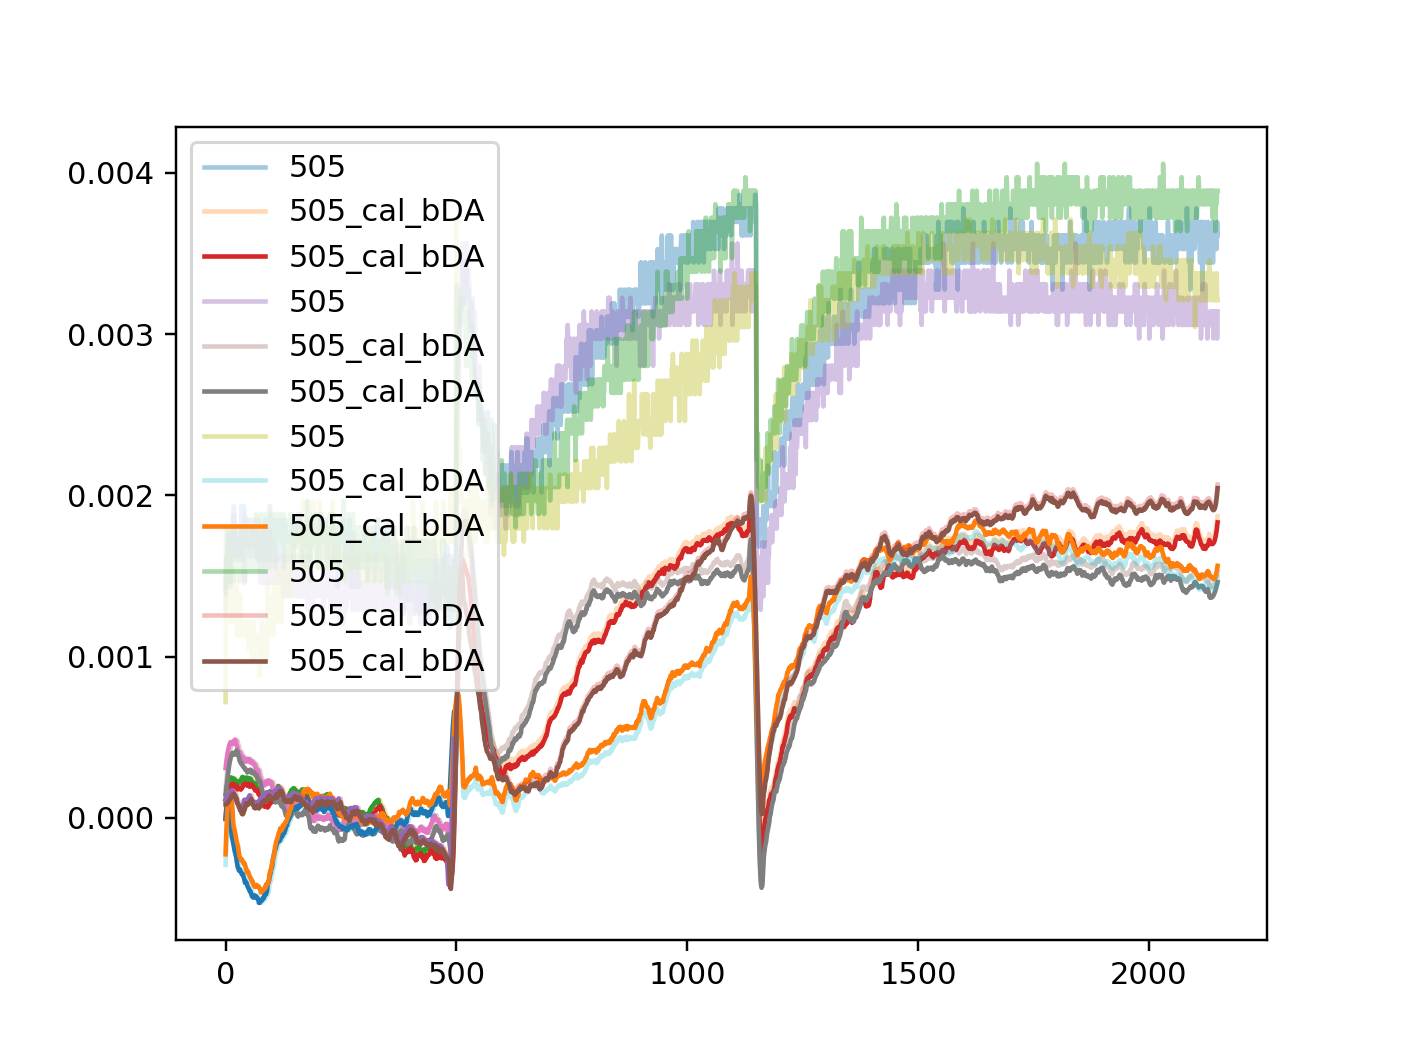

3.893559188587272e-05
6.686177986723571e-05
-6.579832444352646e-05
2.2319207796241915e-05


In [12]:
plt.figure()
I0_points=[4,500]
for t in range(len(sample_df)): #['475']:
    for wl in [505]:
        #plt.plot(sample_df[str(wl)+'_I'][t], label=wl, alpha=.2)
        plt.plot(sample_df[str(wl)+'_calc'][t], label=wl, alpha=.4)
        plt.plot(sample_df[str(wl)+'_bDA'][t], label=str(wl) + '_cal_bDA', alpha=1.3)
        avbl=np.mean(sample_df[str(wl) + '_bDA'][t][I0_points[0]:I0_points[1]])
        print(avbl)
        plt.plot(sample_df[str(wl) + '_bDA'][t][I0_points[0]:I0_points[1]])
        plt.plot(np.array(sample_df[str(wl)+'_bDA'][t])-avbl, label=str(wl) + '_cal_bDA', alpha=1)
        #plt.plot(sample_df[str(wl)+'_calc_s_m_b'][t], label=str(wl) + '_cal_s_mb', alpha=.4)
        #plt.plot(sample_df[str(wl)+'_calc_s_s_m_b'][t], label=str(wl) + '_cal_s_s_mb')
plt.legend()
plt.show()


In [13]:
#generate the "Decay Associated Spectra", i.e. the changes in absorbance at each time point. The
#function will generate an array with each time point containing an array of deltaA values. 
# This function simply trasposes the time/absorbance matrix.
# The function takes in the data frame, the range of wavelengths, the column suffix that designates
# which values to use, and a name for the new column that will hold the results. 
# The funciton generates a new column, in this case called 'das'. 


Ipy.generateDAS(sample_df, wavelengths, '_bDA', 'das')

<IPython.core.display.Javascript object>


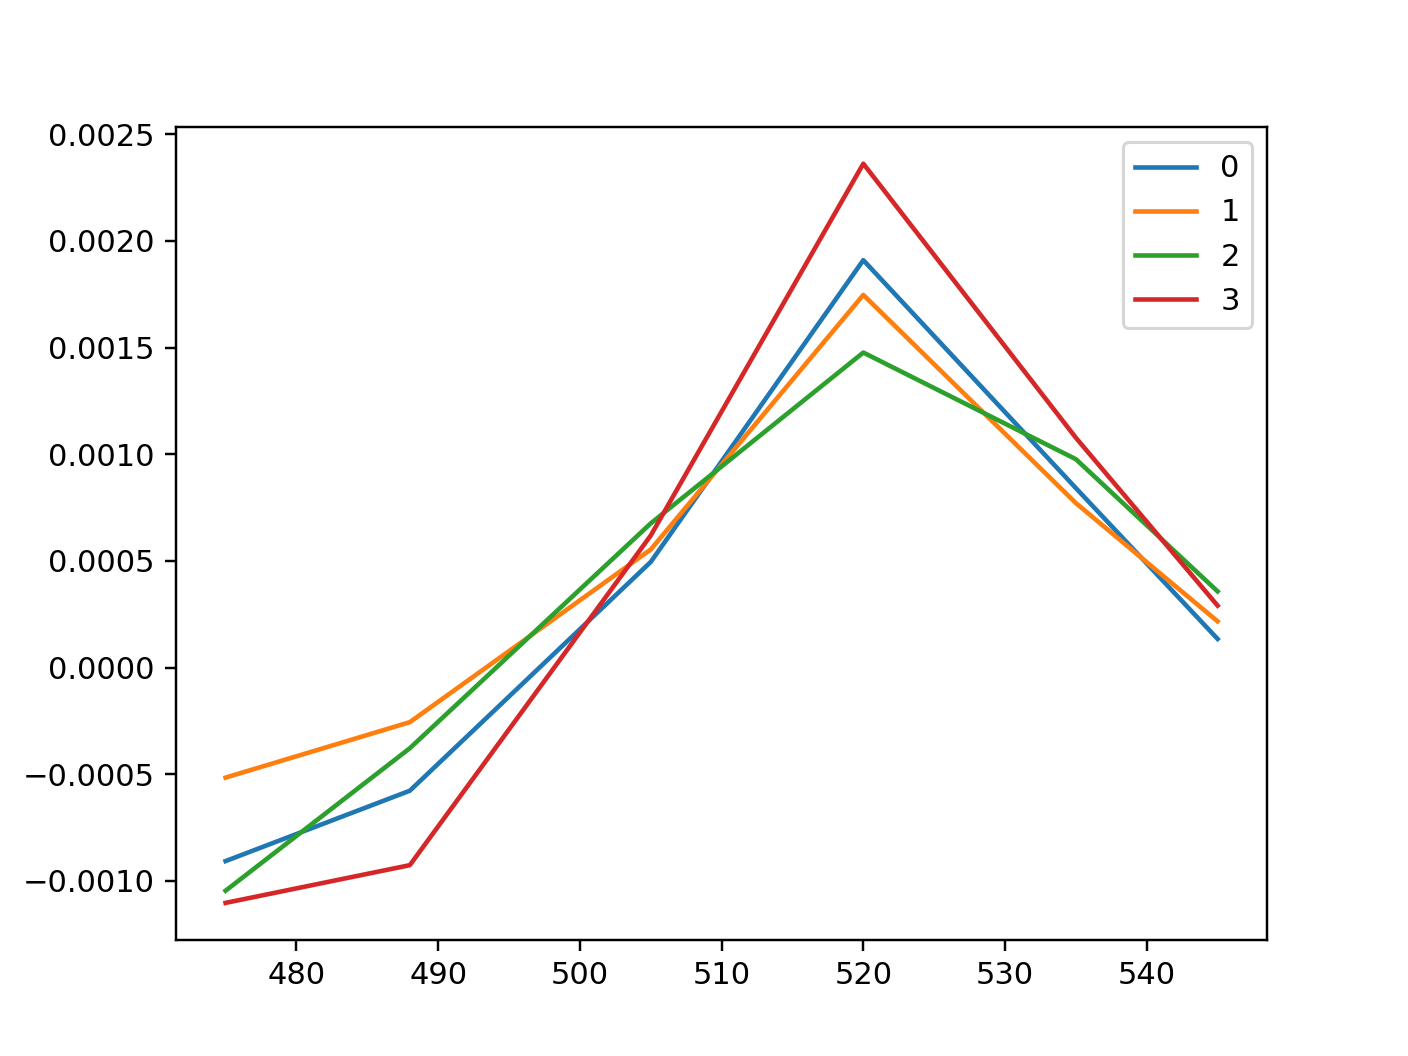

In [14]:
#This graph shows the das of the baseline points, before the light is switched on. It can be useful to see 
# what the "drift" spectum looks like. 


plt.figure()
for i in range(0,4):
    j = len(sample_df['das'][i])-1
    j=500
    plt.plot(wavelengths,sample_df['das'][i][j], alpha=1, label=i)

# e = len(sample_df['das'][1])
# # y=(np.array(sample_df['das'][1][e-1])-np.array(sample_df['das'][1][1100]))

# # plt.plot(wavelengths, y)
# #     j = 50 #len(sample_df['das'][i])-2
# #     plt.plot(wavelengths,sample_df['das'][i][j], alpha=1, label=i)


# #plt.plot(wavelengths,np.array(sample_df['das'][1][j])-np.array(sample_df['das'][0][j]), alpha=1, label=i)

plt.legend()
plt.show()

# 1000*(np.array(sample_df['das'][0][e-1]))

# # e = np.array(sample_df['das'][i][j])
# # e=e/np.max(e)
# # e

# y
i=0
drift_from_traces=1000*np.array(sample_df['das'][i][j])

In [15]:
#wavelengthV=[475,488,505,520,535,545]
ecs,qE,Zx,drift,scatter=Ipy.defineFitCoefficients()

<IPython.core.display.Javascript object>


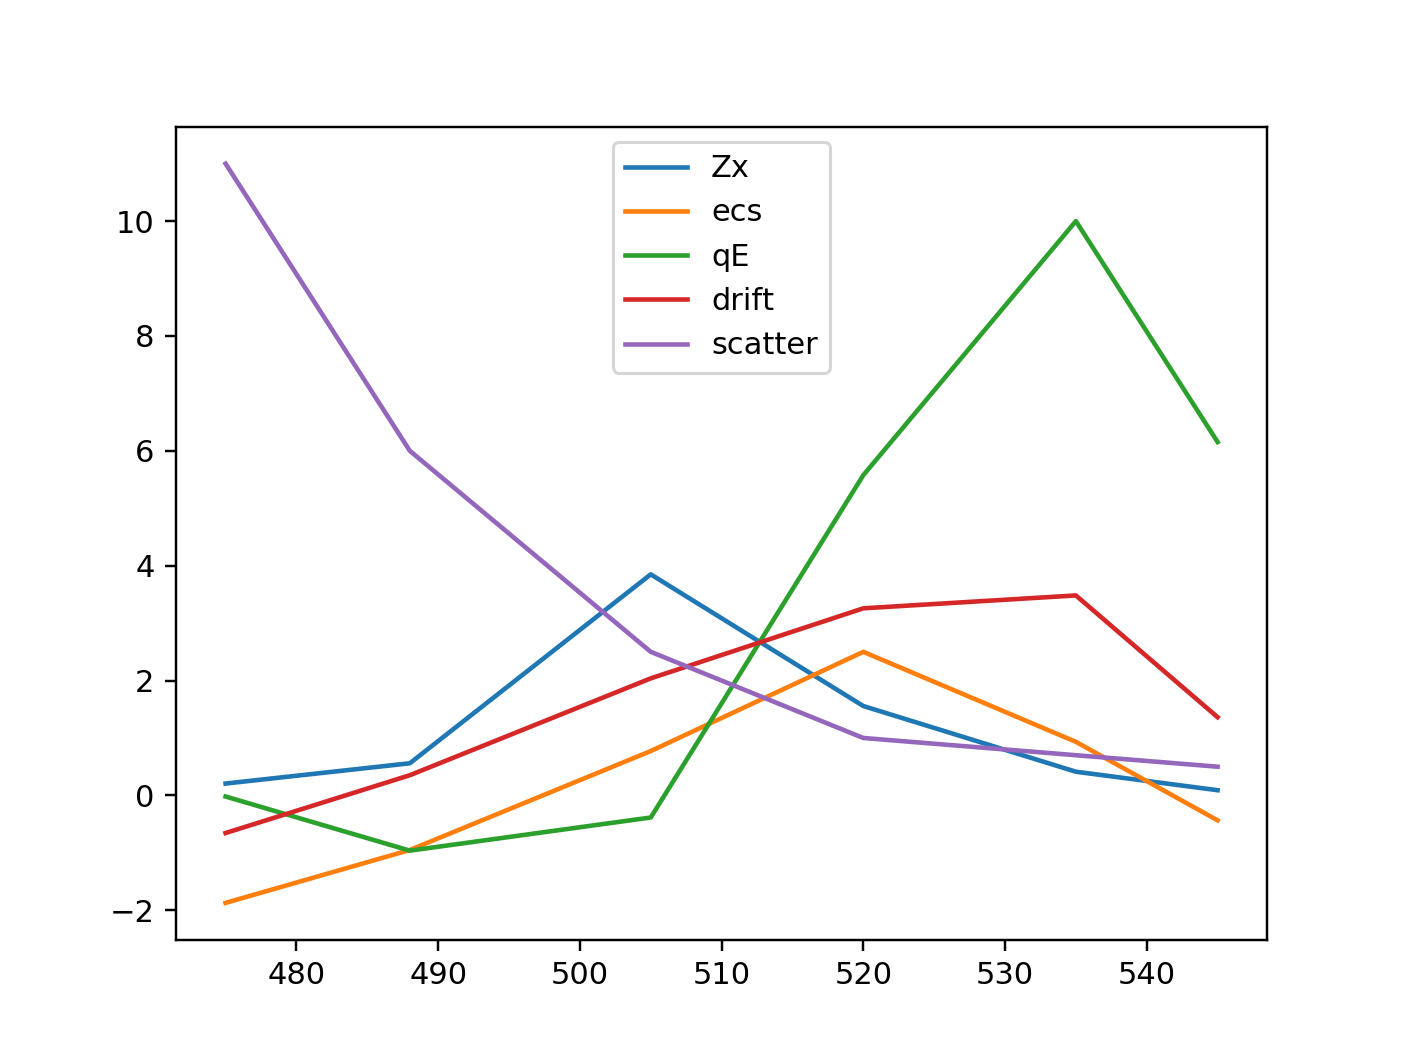

In [16]:

#plot out the spectral coefficients used in the fitting routine.

plt.figure()
plt.plot(wavelengths, Zx, label='Zx')
plt.plot(wavelengths, ecs, label='ecs')
plt.plot(wavelengths, qE, label='qE')
plt.plot(wavelengths, drift, label='drift')
plt.plot(wavelengths, scatter, label='scatter')
plt.legend()
plt.show()  

In [17]:

# Fit das for each time point to the sum of the coefficients described above.
# Note that the spectra are shared with the fit_curve function as global variables so
# tthey need not be entered 

Ipy.fitDAS_5(sample_df, wavelengths, 'das', newSuffix='')


#subtractSameBaselineFromAllTraces(sample_df, ['ecs', 'qE','Zx'], '', 3,[1,10])


<IPython.core.display.Javascript object>


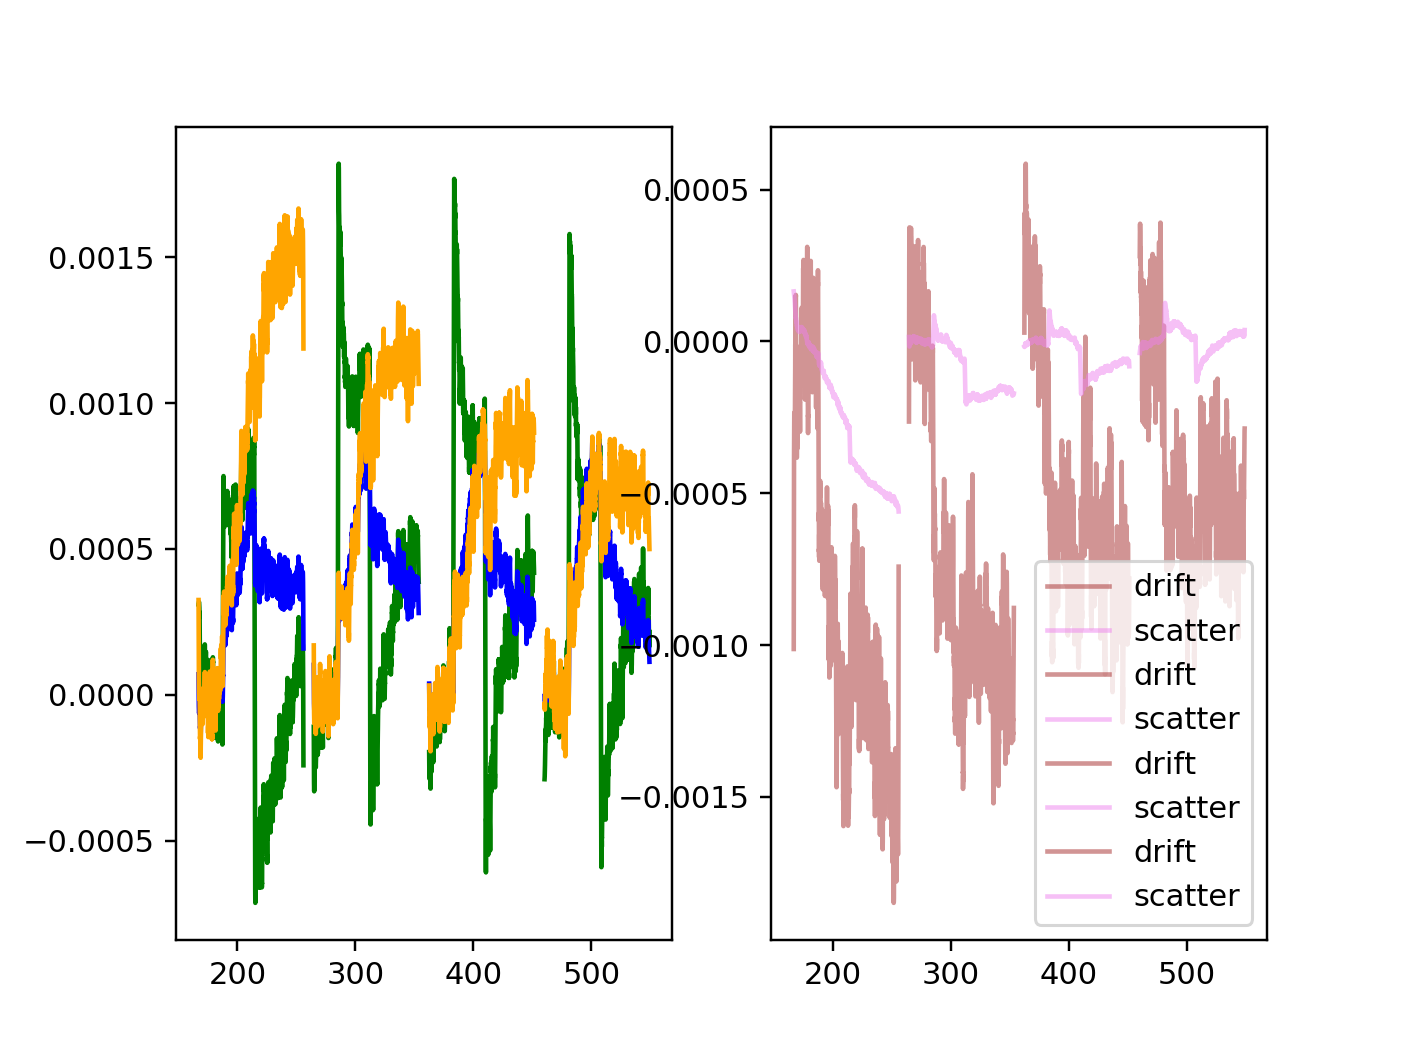

In [18]:
fig=plt.figure()
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for i in range(len(sample_df)):
    ax1.plot(sample_df['505_time'][i], sample_df['ecs'][i], color='green', label='ecs', alpha=1)
    ax1.plot(sample_df['505_time'][i], sample_df['qE'][i], color='blue', label='qE', alpha=1)
    ax1.plot(sample_df['505_time'][i], sample_df['Zx'][i], color='orange', label='Zx', alpha=1)
    ax2.plot(sample_df['505_time'][i], sample_df['drift'][i], color='brown', label='drift', alpha=.5)
    ax2.plot(sample_df['505_time'][i], sample_df['scatter'][i], color='violet', label='scatter', alpha=.5)
#ax1.legend()
ax2.legend()

    
plt.show()

In [19]:
# Average the results  from the second through the 4th re[eats of the 
# trace the function and add the suffix 'avg' to the new columns

rows_to_average=[1,2,3]
columns_to_average=['ecs','qE','Zx','scatter', 'drift']
label_for_new_averaged_row='avg'
Ipy.compute_average_row( sample_df, rows_to_average, columns_to_average, label_for_new_averaged_row)

In [24]:
#sample_df

<IPython.core.display.Javascript object>


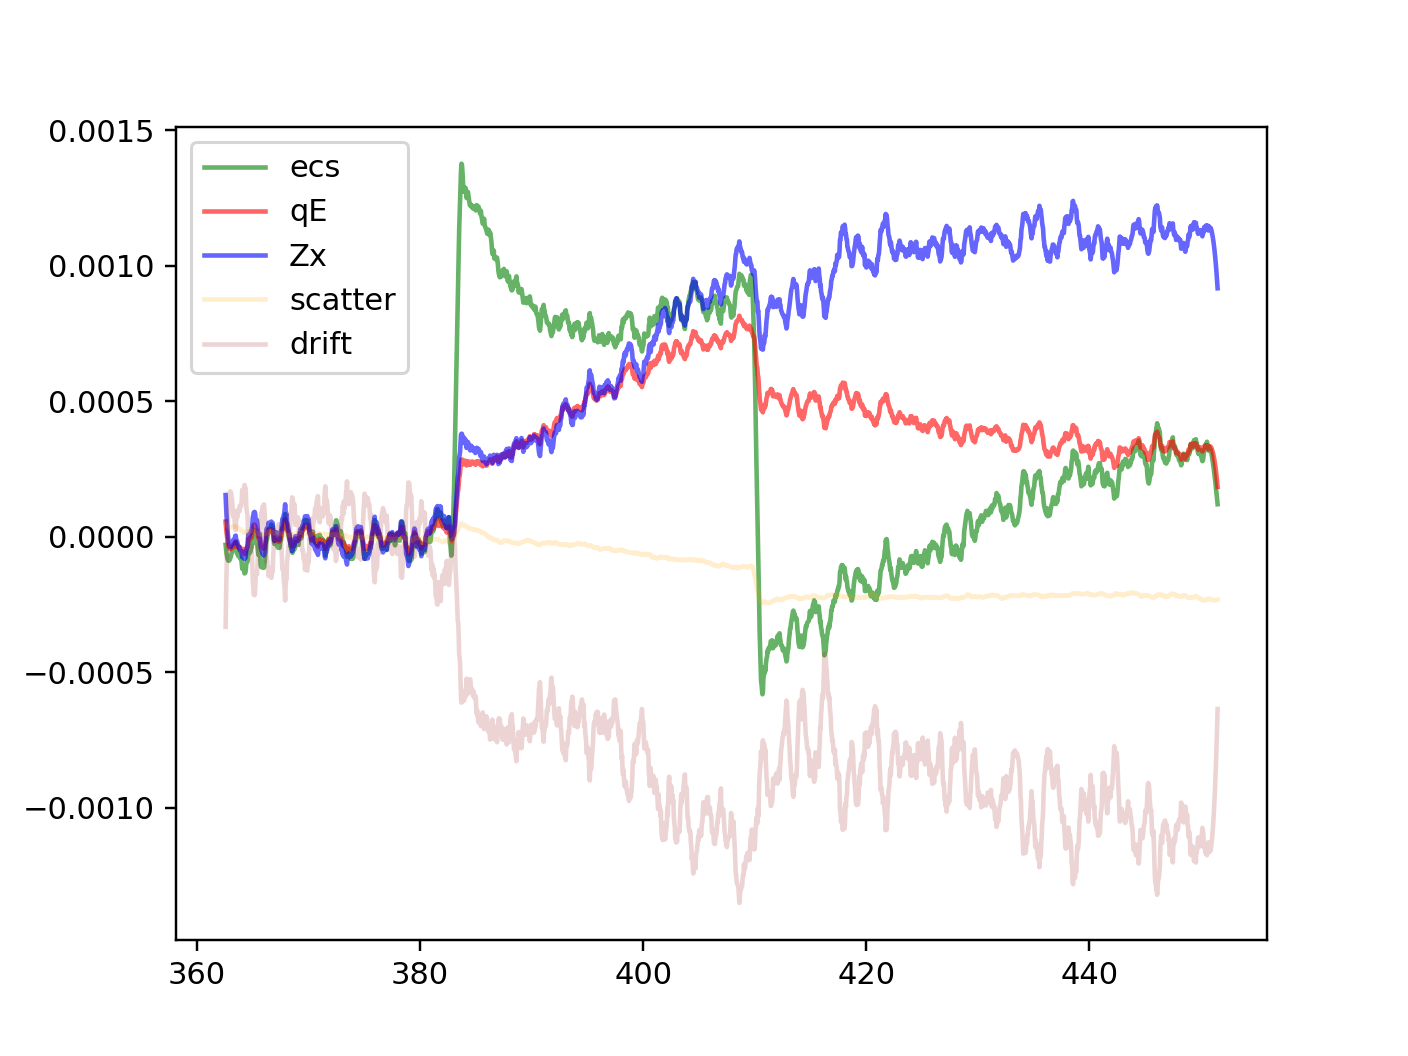

In [21]:
plt.figure()
i='avg'
plt.plot(sample_df['505_time'][0], sample_df.loc[i]['ecs'], color='green', label='ecs', alpha=.6)
plt.plot(sample_df['505_time'][0], sample_df.loc[i]['qE'], color='red', label='qE', alpha=.6)
plt.plot(sample_df['505_time'][0], sample_df.loc[i]['Zx'], color='blue', label='Zx', alpha=.6)
plt.plot(sample_df['505_time'][0], sample_df.loc[i]['scatter'], color='orange', label='scatter', alpha=.2)
plt.plot(sample_df['505_time'][0], sample_df.loc[i]['drift'], color='brown', label='drift', alpha=.2)


plt.legend()

# plt.plot(sample_df['505_time'][i], sample_df['qE'][i], color='blue', label='qE', alpha=.6)
# plt.plot(sample_df['505_time'][i], sample_df['Zx'][i], color='orange', label='Zx', alpha=.6)
plt.show()
